# Hybrid Dual Model: Hybrid Physics-Neural Network Model Led by a GMM

This notebook uses a Gaussian Mixture Model to segment out the pre-shot data, then use that initial trajectory in a physics-based model, assisted by predicting variables with a neural network (XGBoost???)

## 1. Import Required Libraries

In [1]:
import json
from pathlib import Path
from typing import List, Optional, Tuple
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gmm_training as gmmt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Ensure updated modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2
import importlib
import physics.constants as const
importlib.reload(const)
from physics.constants import R_WORLD_TO_RIM, R_HOOP_WORLD, T_WORLD_TO_RIM
print('physics.constants reloaded')

physics.constants reloaded


## 2 Load and Preprocess the Data (Sahar's GMM Code)

In [3]:
# Load training data
csv_path = "train.csv"
cols_to_remove = ["id", "shot_id", "angle", "depth", "left_right"]
shots, valid_row_idx, signal_cols = gmmt.load_shots_from_csv(csv_path, cols_to_remove)
X = gmmt.stack_timepoints(shots)

Kept 345 / 345 shots after parsing + NaN handling.
n_signals = 207
Example shot shape = (207, 240)  (n_signals, T)


In [4]:
print(len(shots))

345


In [5]:
# DEBUGGING
# print(signal_cols)
print(len(signal_cols))
print(X)
print(X.shape)

207
[[ 19.01590226 -25.31563021   6.03498407 ...  19.80148231 -25.09736861
    5.67832856]
 [ 19.01461213 -25.31434213   6.03402481 ...  19.80096755 -25.09666874
    5.67808322]
 [ 19.01305554 -25.31147912   6.03195258 ...  19.79903398 -25.09434964
    5.67657178]
 ...
 [ 19.00927286 -25.59904174   5.78994893 ...  19.3177156  -25.59881604
    5.15283271]
 [ 18.97719557 -25.58376682   5.72189022 ...  19.31911423 -25.59985866
    5.15516152]
 [ 18.96823877 -25.57612101   5.71164999 ...  19.32272138 -25.60015898
    5.15253393]]
(82800, 207)


## 3.1 Build Gaussian Mixture Model

In [6]:
# Run the gmm model.

scaler, gmm = gmmt.fit_scaler_gmm(X, n_components=5, seed=42)
labels, probs = gmmt.export_per_shot_outputs(shots, scaler, gmm)

In [7]:
print(labels[1].shape)
print(shots[1].shape)

(240,)
(207, 240)


In [8]:
# Create a variable with all columns that contain the word 'finger' or 'wrist'
hand_names = [col for col in signal_cols if 'finger' in col.lower() or 'wrist' in col.lower()]
print(f"Hand-related columns (containing 'finger' or 'wrist'): {hand_names}")

Hand-related columns (containing 'finger' or 'wrist'): ['left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_first_finger_cmc_x', 'left_first_finger_cmc_y', 'left_first_finger_cmc_z', 'left_first_finger_mcp_x', 'left_first_finger_mcp_y', 'left_first_finger_mcp_z', 'left_first_finger_ip_x', 'left_first_finger_ip_y', 'left_first_finger_ip_z', 'left_first_finger_distal_x', 'left_first_finger_distal_y', 'left_first_finger_distal_z', 'left_second_finger_mcp_x', 'left_second_finger_mcp_y', 'left_second_finger_mcp_z', 'left_second_finger_pip_x', 'left_second_finger_pip_y', 'left_second_finger_pip_z', 'left_second_finger_dip_x', 'left_second_finger_dip_y', 'left_second_finger_dip_z', 'left_second_finger_distal_x', 'left_second_finger_distal_y', 'left_second_finger_distal_z', 'left_third_finger_mcp_x', 'left_third_finger_mcp_y', 'left_third_finger_mcp_z', 'left_third_finger_pip_x', 'left_third_finger_pip_y', 'left_third_finger_pip_z', 'left_th

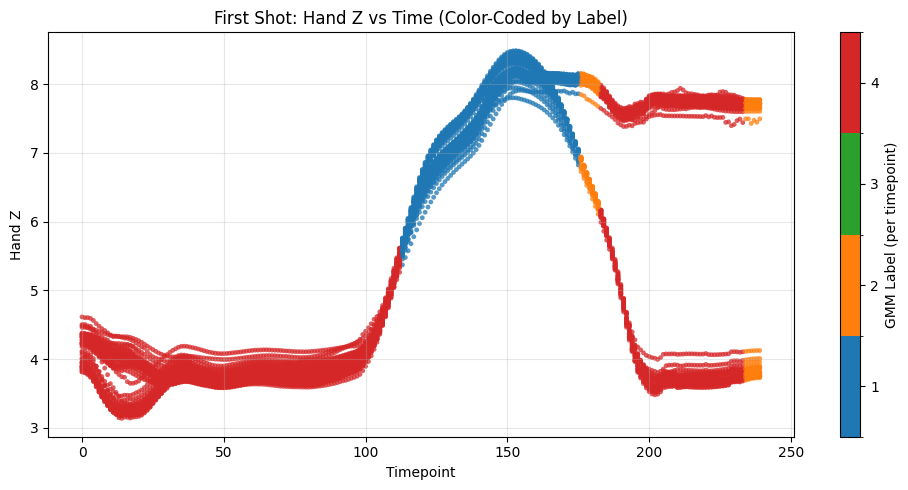

In [9]:
# Plot hand z-position over time for the first shot with GMM label color-coding
from matplotlib.colors import ListedColormap, BoundaryNorm

first_shot = shots[0]
first_labels = np.asarray(labels[0])
col_to_idx = {name: i for i, name in enumerate(signal_cols)}

# Use hand-related z columns (labels are per-timepoint from hand-based segmentation)
hand_z_cols = [c for c in hand_names if c.lower().endswith('_z')]
if not hand_z_cols:
    raise ValueError("No hand z columns found in hand_names.")

time = np.arange(first_shot.shape[1])

# Fixed 4-state discrete color mapping
state_values = [1, 2, 3, 4]
state_to_idx = {state: idx for idx, state in enumerate(state_values)}
color_values = np.array([state_to_idx.get(int(label), np.nan) for label in first_labels], dtype=float)
cmap = ListedColormap(plt.cm.tab10(np.arange(4)))
norm = BoundaryNorm(np.arange(-0.5, 4.5, 1), cmap.N)

fig, ax = plt.subplots(figsize=(10, 5))

for z_col in hand_z_cols:
    z_t = first_shot[col_to_idx[z_col], :]
    ax.scatter(time, z_t, c=color_values, cmap=cmap, norm=norm, s=12, alpha=0.75, edgecolors='none')

# Discrete 4-color colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(4))
cbar.ax.set_yticklabels([str(state) for state in state_values])
cbar.set_label('GMM Label (per timepoint)')

ax.set_xlabel('Timepoint')
ax.set_ylabel('Hand Z')
ax.set_title('First Shot: Hand Z vs Time (Color-Coded by Label)')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

## 4. Prepare Initial Trajectory Data

In [40]:
from physics.extract_features import estimate_ball_motion

# Build launch-state features using frames from GMM state == 1.
# Output order per shot: [x, y, z, vx, vy, vz, wx, wy, wz]
LAST_N = 10
FPS = 60.0

col_to_idx = {name: i for i, name in enumerate(signal_cols)}
hand_cols = [c for c in signal_cols if ("finger" in c.lower() or "wrist" in c.lower())]

def hand_points_from_shot(shot, side_prefix, frame_indices=None):
    bases = sorted(
        {
            c[:-2]
            for c in hand_cols
            if c.startswith(f"{side_prefix}_") and c.endswith("_x")
        }
    )

    if frame_indices is None:
        frame_indices = np.arange(shot.shape[1] - LAST_N, shot.shape[1])
    frame_indices = np.asarray(frame_indices, dtype=int)

    points = []
    for base in bases:
        x_name, y_name, z_name = f"{base}_x", f"{base}_y", f"{base}_z"
        if x_name in col_to_idx and y_name in col_to_idx and z_name in col_to_idx:
            xyz = np.stack(
                [
                    shot[col_to_idx[x_name], frame_indices],
                    shot[col_to_idx[y_name], frame_indices],
                    shot[col_to_idx[z_name], frame_indices],
                ],
                axis=-1,
            )  # (n_frames, 3)
            points.append(xyz)

    if not points:
        raise ValueError(f"No valid {side_prefix} hand landmarks found with x/y/z columns.")

    return np.stack(points, axis=1)  # (n_frames, n_points, 3)

launch_states = np.zeros((len(shots), 9), dtype=float)

for i, shot in enumerate(shots):
    shot_labels = np.asarray(labels[i])
    label1_idx = np.flatnonzero(shot_labels == 1)

    if label1_idx.size < LAST_N:
        raise ValueError(
            f"Shot {i} has only {label1_idx.size} frames with label==1; need at least {LAST_N}."
        )

    # Keep window strictly in GMM state 1 (last LAST_N frames of state 1).
    frame_idx = label1_idx[-LAST_N:]
    timestamps = frame_idx.astype(float) / FPS

    left_points = hand_points_from_shot(shot, "left", frame_idx)
    right_points = hand_points_from_shot(shot, "right", frame_idx)

    v_avg, omega_avg, pos_avg, v_frames, omega_frames, centers = estimate_ball_motion(
        left_points=left_points,
        right_points=right_points,
        timestamps=timestamps,
        return_per_frame=True,
    )

    # Select launch estimate from an ascending moment within state-1 window
    # instead of always taking the last (typically descending) frame.
    if len(v_frames):
        launch_k = int(np.argmax(v_frames[:, 2]))  # max vz within state-1 window
        v_launch = v_frames[launch_k]
        omega_launch = omega_frames[launch_k] if len(omega_frames) else omega_avg
        center_k = min(launch_k + 1, len(centers) - 1) if len(centers) else None
        pos_launch = centers[center_k] if center_k is not None else pos_avg
    else:
        v_launch = v_avg
        omega_launch = omega_avg
        pos_launch = pos_avg

    launch_states[i] = np.concatenate([pos_launch, v_launch, omega_launch])

print("launch_states shape:", launch_states.shape)
print("Expected shots:", len(shots))
print("First shot state [x,y,z,vx,vy,vz,wx,wy,wz]:", launch_states[0])

launch_states shape: (345, 9)
Expected shots: 345
First shot state [x,y,z,vx,vy,vz,wx,wy,wz]: [ 18.50499294 -25.25181648   7.92147946   0.22120092   1.20027843
  -2.16172505   2.46654895   1.88751679  -1.43901397]


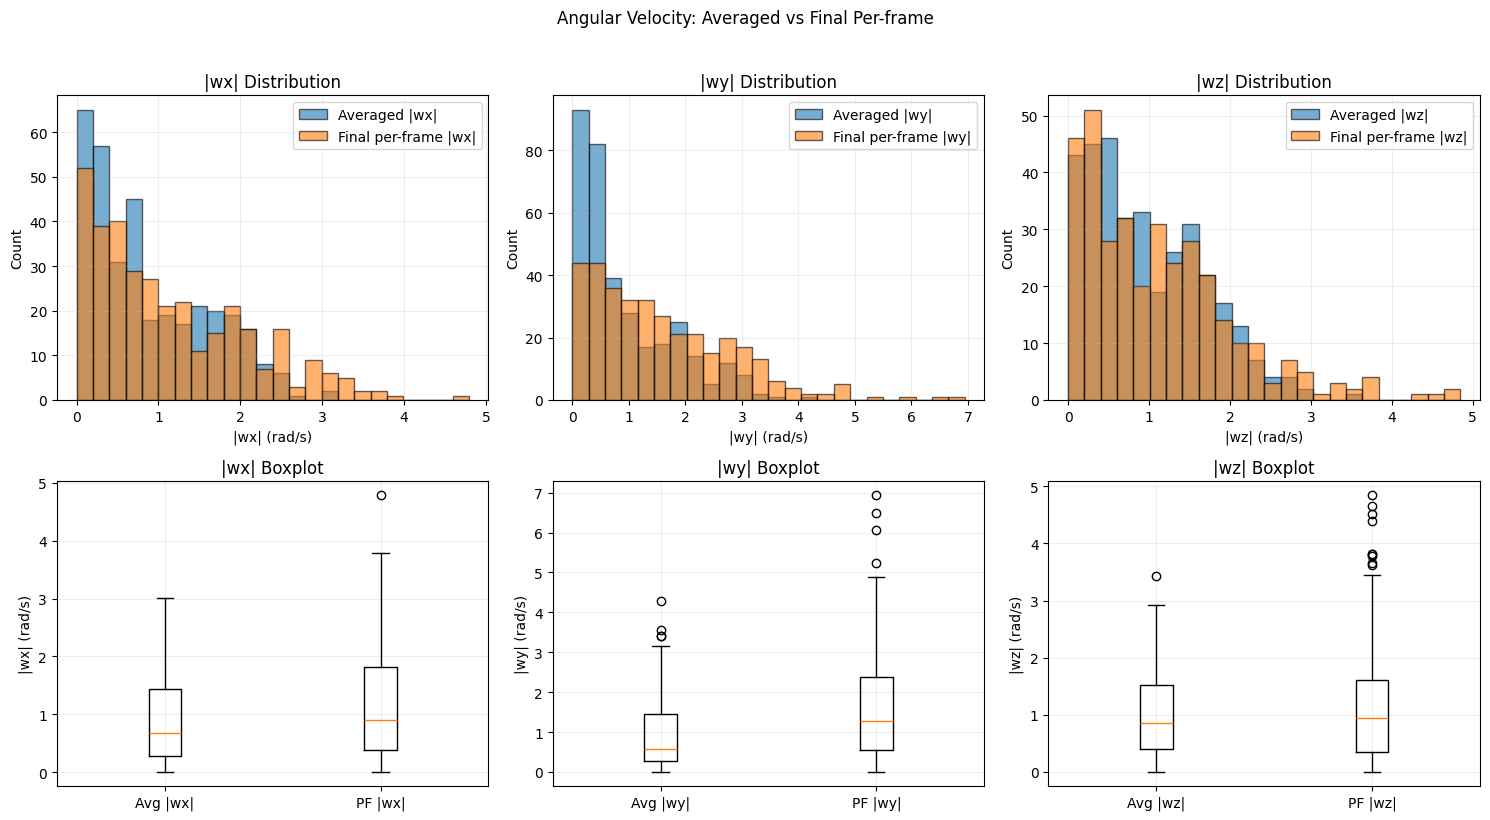

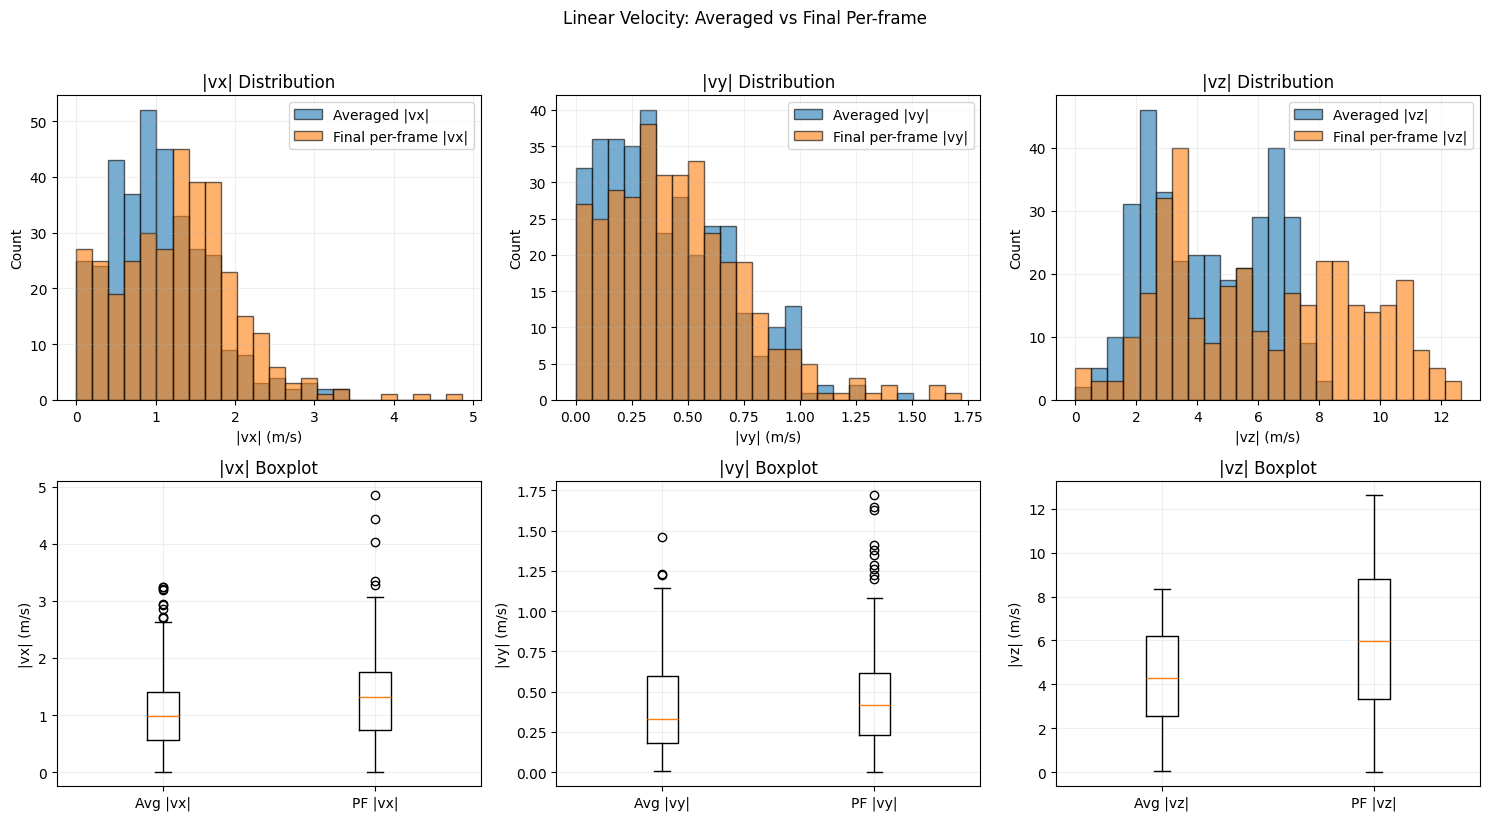

|wx|  Averaged mean/median/max: 0.8866 / 0.6751 / 3.0118
|wx|  Per-frame mean/median/max: 1.1467 / 0.9063 / 4.7924
|wy|  Averaged mean/median/max: 0.9239 / 0.5660 / 4.2854
|wy|  Per-frame mean/median/max: 1.5741 / 1.2884 / 6.9417
|wz|  Averaged mean/median/max: 0.9825 / 0.8645 / 3.4352
|wz|  Per-frame mean/median/max: 1.1155 / 0.9493 / 4.8472
|vx|  Averaged mean/median/max: 1.0466 / 0.9777 / 3.2456
|vx|  Per-frame mean/median/max: 1.2827 / 1.3163 / 4.8540
|vy|  Averaged mean/median/max: 0.4031 / 0.3326 / 1.4585
|vy|  Per-frame mean/median/max: 0.4549 / 0.4192 / 1.7206
|vz|  Averaged mean/median/max: 4.3278 / 4.2958 / 8.3348
|vz|  Per-frame mean/median/max: 6.2121 / 5.9639 / 12.6321


In [28]:
# Compare averaged vs final per-frame estimates by axis using absolute values
v_avg = launch_states[:, 3:6]       # columns: vx, vy, vz
omega_avg = launch_states[:, 6:9]   # columns: wx, wy, wz

v_pf = np.zeros((len(shots), 3), dtype=float)
omega_pf = np.zeros((len(shots), 3), dtype=float)
for i, shot in enumerate(shots):
    shot_labels = np.asarray(labels[i])
    label1_idx = np.flatnonzero(shot_labels == 1)
    if label1_idx.size < LAST_N:
        raise ValueError(f"Shot {i} has only {label1_idx.size} frames with label==1; need at least {LAST_N}.")

    frame_idx = label1_idx[-LAST_N:]
    ts = frame_idx.astype(float) / FPS

    left_points = hand_points_from_shot(shot, "left", frame_idx)
    right_points = hand_points_from_shot(shot, "right", frame_idx)

    v_window_avg, omega_window_avg, _, v_frames, omega_frames, _ = estimate_ball_motion(
        left_points=left_points,
        right_points=right_points,
        timestamps=ts,
        return_per_frame=True,
    )

    v_pf[i] = v_frames[-1] if len(v_frames) else v_window_avg
    omega_pf[i] = omega_frames[-1] if len(omega_frames) else omega_window_avg

# ---------- Angular velocity plots ----------
omega_avg_abs = np.abs(omega_avg)
omega_pf_abs = np.abs(omega_pf)
omega_axes = ["wx", "wy", "wz"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for j, axis in enumerate(omega_axes):
    axis_max = max(omega_avg_abs[:, j].max(), omega_pf_abs[:, j].max())
    bins = np.linspace(0, axis_max if axis_max > 0 else 1.0, 25)
    axes[0, j].hist(omega_avg_abs[:, j], bins=bins, alpha=0.6, label=f"Averaged |{axis}|", edgecolor='black')
    axes[0, j].hist(omega_pf_abs[:, j], bins=bins, alpha=0.6, label=f"Final per-frame |{axis}|", edgecolor='black')
    axes[0, j].set_title(f"|{axis}| Distribution")
    axes[0, j].set_xlabel(f"|{axis}| (rad/s)")
    axes[0, j].set_ylabel("Count")
    axes[0, j].legend()
    axes[0, j].grid(alpha=0.2)

    axes[1, j].boxplot([omega_avg_abs[:, j], omega_pf_abs[:, j]], labels=[f"Avg |{axis}|", f"PF |{axis}|"] )
    axes[1, j].set_title(f"|{axis}| Boxplot")
    axes[1, j].set_ylabel(f"|{axis}| (rad/s)")
    axes[1, j].grid(alpha=0.2)

fig.suptitle("Angular Velocity: Averaged vs Final Per-frame", y=1.02)
fig.tight_layout()
plt.show()

# ---------- Linear velocity plots ----------
v_avg_abs = np.abs(v_avg)
v_pf_abs = np.abs(v_pf)
v_axes = ["vx", "vy", "vz"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for j, axis in enumerate(v_axes):
    axis_max = max(v_avg_abs[:, j].max(), v_pf_abs[:, j].max())
    bins = np.linspace(0, axis_max if axis_max > 0 else 1.0, 25)
    axes[0, j].hist(v_avg_abs[:, j], bins=bins, alpha=0.6, label=f"Averaged |{axis}|", edgecolor='black')
    axes[0, j].hist(v_pf_abs[:, j], bins=bins, alpha=0.6, label=f"Final per-frame |{axis}|", edgecolor='black')
    axes[0, j].set_title(f"|{axis}| Distribution")
    axes[0, j].set_xlabel(f"|{axis}| (m/s)")
    axes[0, j].set_ylabel("Count")
    axes[0, j].legend()
    axes[0, j].grid(alpha=0.2)

    axes[1, j].boxplot([v_avg_abs[:, j], v_pf_abs[:, j]], labels=[f"Avg |{axis}|", f"PF |{axis}|"] )
    axes[1, j].set_title(f"|{axis}| Boxplot")
    axes[1, j].set_ylabel(f"|{axis}| (m/s)")
    axes[1, j].grid(alpha=0.2)

fig.suptitle("Linear Velocity: Averaged vs Final Per-frame", y=1.02)
fig.tight_layout()
plt.show()

# Summary stats
for j, axis in enumerate(omega_axes):
    print(f"|{axis}|  Averaged mean/median/max: {omega_avg_abs[:, j].mean():.4f} / {np.median(omega_avg_abs[:, j]):.4f} / {omega_avg_abs[:, j].max():.4f}")
    print(f"|{axis}|  Per-frame mean/median/max: {omega_pf_abs[:, j].mean():.4f} / {np.median(omega_pf_abs[:, j]):.4f} / {omega_pf_abs[:, j].max():.4f}")

for j, axis in enumerate(v_axes):
    print(f"|{axis}|  Averaged mean/median/max: {v_avg_abs[:, j].mean():.4f} / {np.median(v_avg_abs[:, j]):.4f} / {v_avg_abs[:, j].max():.4f}")
    print(f"|{axis}|  Per-frame mean/median/max: {v_pf_abs[:, j].mean():.4f} / {np.median(v_pf_abs[:, j]):.4f} / {v_pf_abs[:, j].max():.4f}")

In [30]:
# Save launch-state features (one row per shot)
launch_state_columns = [
    "x", "y", "z",
    "vx", "vy", "vz",
    "wx", "wy", "wz",
]

launch_states_df = pd.DataFrame(launch_states, columns=launch_state_columns)
launch_states_path = "launch_states.csv"
launch_states_df.to_csv(launch_states_path, index=False)

print(f"Saved {launch_states_df.shape[0]} shots x {launch_states_df.shape[1]} states to {launch_states_path}")
launch_states_df.head()

Saved 345 shots x 9 states to launch_states.csv


,x,y,z,vx,vy,vz,wx,wy,wz
0,18.665847,-25.198421,7.529581,1.595768,0.080895,-2.765285,3.091824,0.894374,-1.019311
1,19.089367,-25.447288,7.110290,-0.727968,-0.096830,-7.725672,-0.716857,0.200481,-2.876728
2,18.706947,-25.133750,7.727873,1.367357,-0.001873,-3.302548,2.663712,2.033724,-0.949743
3,18.720054,-25.275765,7.589272,0.688957,-0.249325,-3.594532,2.131708,2.807582,-0.621966
4,18.694073,-25.357056,7.389011,-0.229068,-0.783027,-3.632636,2.978739,1.997759,-1.097979


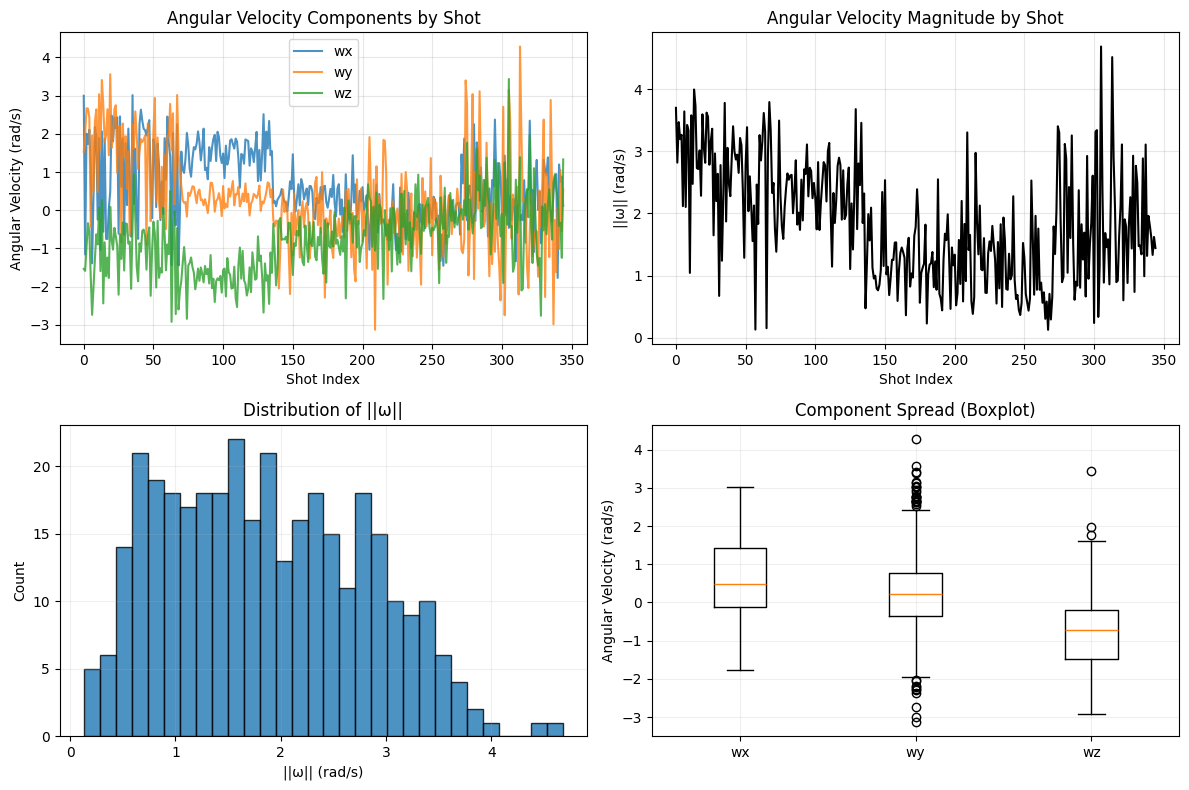

mean ||ω||: 1.8560 rad/s
median ||ω||: 1.7907 rad/s
max ||ω||: 4.6836 rad/s


In [26]:
# Feature Generation: inspect angular velocities
omega = launch_states[:, 6:9]  # [wx, wy, wz]
omega_mag = np.linalg.norm(omega, axis=1)
shot_idx = np.arange(len(omega))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Component values by shot
axes[0, 0].plot(shot_idx, omega[:, 0], label='wx', alpha=0.8)
axes[0, 0].plot(shot_idx, omega[:, 1], label='wy', alpha=0.8)
axes[0, 0].plot(shot_idx, omega[:, 2], label='wz', alpha=0.8)
axes[0, 0].set_title('Angular Velocity Components by Shot')
axes[0, 0].set_xlabel('Shot Index')
axes[0, 0].set_ylabel('Angular Velocity (rad/s)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Magnitude by shot
axes[0, 1].plot(shot_idx, omega_mag, color='black')
axes[0, 1].set_title('Angular Velocity Magnitude by Shot')
axes[0, 1].set_xlabel('Shot Index')
axes[0, 1].set_ylabel('||ω|| (rad/s)')
axes[0, 1].grid(alpha=0.3)

# Histogram of magnitudes
axes[1, 0].hist(omega_mag, bins=30, edgecolor='black', alpha=0.8)
axes[1, 0].set_title('Distribution of ||ω||')
axes[1, 0].set_xlabel('||ω|| (rad/s)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(alpha=0.2)

# Boxplot for wx/wy/wz
axes[1, 1].boxplot([omega[:, 0], omega[:, 1], omega[:, 2]], labels=['wx', 'wy', 'wz'])
axes[1, 1].set_title('Component Spread (Boxplot)')
axes[1, 1].set_ylabel('Angular Velocity (rad/s)')
axes[1, 1].grid(alpha=0.2)

fig.tight_layout()
plt.show()

print(f'mean ||ω||: {omega_mag.mean():.4f} rad/s')
print(f'median ||ω||: {np.median(omega_mag):.4f} rad/s')
print(f'max ||ω||: {omega_mag.max():.4f} rad/s')

## 5. Build Neural Network Component

In [35]:
# Use existing coefficient helpers + constants
from physics.dynamics import compute_alphas, compute_lift_coefficient
import physics.constants as const
from model.modify_parameters import zero_centered_softplus

AIR_DENSITY = const.AIR_DENSITY
BALL_AREA = const.BALL_AREA
BALL_MASS = const.BALL_MASS
DRAG_COEFFICIENT = const.DRAG_COEFFICIENT
SPIN_FACTOR = getattr(const, "SPIN_FACTOR", 0.2)
CL_MAX = getattr(const, "CL_MAX", 0.6)

# Initialize learnable parameter adjustments
delta_rho = torch.tensor(0.0, requires_grad=True)
delta_D = torch.tensor(0.0, requires_grad=True)
delta_k = torch.tensor(0.0, requires_grad=True)

def build_aero_coefficients_from_factors(
    state: torch.Tensor,
    delta_rho: torch.Tensor = delta_rho,
    delta_D: torch.Tensor = delta_D,
    delta_k: torch.Tensor = delta_k
):
    """Build Cd, Cl, alpha_d, alpha_l using provided learnable factors.

    - delta_rho modifies density via compute_alphas (rho = rho0 * exp(delta_rho)).
    - delta_D modifies baseline drag coefficient Cd.
    - delta_k scales spin->lift sensitivity used by compute_lift_coefficient.
    """
    # Keep default equal to baseline at delta=0, but smoothly trainable
    Cd = DRAG_COEFFICIENT * zero_centered_softplus(delta_D)
    spin_gain = SPIN_FACTOR * torch.exp(delta_k)

    Cl = compute_lift_coefficient(
        spin_ratio=spin_gain,
        Cl_max=CL_MAX,
        state=state,
    )

    alpha_d, alpha_l = compute_alphas(
        delta_rho=delta_rho,
        Cd=Cd,
        Cl=Cl,
        A=BALL_AREA,
        m0=BALL_MASS,
        rho0=AIR_DENSITY,
    )

    return Cd, Cl, alpha_d, alpha_l

ImportError: cannot import name 'SPIN_FACTOR' from 'physics.constants' (c:\Users\caitken5.stu\Documents\GitHub\CMSZ-SPLxUTSPAN-2026-Data-Challenge\physics\constants.py)

In [36]:
# Train the lightweight delta optimizer (smoke test on subset)
from model.delta_optimizer import train_delta_parameters
from physics.rollout import scale_targets_fixed_ranges
from physics.constants import FEET_TO_METERS

# Prepare training data: launch states -> scaled [angle, depth, left_right] targets
# launch_states from hand landmarks are in feet; convert position/velocity to SI for physics rollout.
launch_states_si = launch_states.copy()
launch_states_si[:, 0:6] *= FEET_TO_METERS
initial_states = torch.tensor(launch_states_si, dtype=torch.float32)

# Align labels with shots using valid_row_idx from preprocessing
target_df = pd.read_csv("train.csv").loc[valid_row_idx, ["angle", "depth", "left_right"]].reset_index(drop=True)
target_raw = torch.tensor(target_df.values, dtype=torch.float32)
target_scaled = scale_targets_fixed_ranges(target_raw)

# Start small for speed; scale up subset_size/epochs after this runs
subset_size = min(64, initial_states.shape[0])
train_states = initial_states[:subset_size]
train_targets = target_scaled[:subset_size]

result = train_delta_parameters(
    initial_states=train_states,
    targets_at_plane=train_targets,
    prediction_space="scaled_metrics",
    epochs=80,
    lr=1e-2,
    dt=1e-3,
    t_max=3.0,
    verbose=True,
)

print("\nFinal learned deltas:")
print(f"delta_rho = {result.delta_rho:+.6f}")
print(f"delta_D   = {result.delta_D:+.6f}")
print(f"delta_k   = {result.delta_k:+.6f}")

plt.figure(figsize=(7, 4))
plt.plot(result.losses)
plt.xlabel("Epoch")
plt.ylabel("NLS Loss")
plt.title("Delta Optimizer Training Loss (Scaled Angle/Depth/LR)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

epoch=000 loss=754.391479 delta_rho=+0.0100 delta_D=+0.0100 delta_k=+0.0100


KeyboardInterrupt: 

In [41]:
# Quick verification: rollout_to_plane now returns rim-frame state
from physics.rollout import rollout_to_plane, state_at_plane_to_targets
from physics.constants import FEET_TO_METERS
from model.delta_optimizer import DeltaParameterModel

# Use first launch state as a smoke test (convert pos/vel from feet to meters for physics rollout)
s0_np = launch_states[0].copy()
s0_np[0:6] *= FEET_TO_METERS
s0 = torch.tensor(s0_np, dtype=torch.float32)
delta_model = DeltaParameterModel()
params = delta_model.build_params(s0.unsqueeze(0))

t_hit, s_hit_rim = rollout_to_plane(s0=s0, params=params)
targets_native = state_at_plane_to_targets(s_hit_rim)  # [angle_deg, depth_in, left_right_in]

print(f"t_hit: {float(t_hit):.6f} s")
print("rim-frame position [x, y, z] (m):", s_hit_rim[0:3].detach().cpu().numpy())
print("rim-frame velocity [vx, vy, vz] (m/s):", s_hit_rim[3:6].detach().cpu().numpy())
print("rim-frame omega [wx, wy, wz] (rad/s):", s_hit_rim[6:9].detach().cpu().numpy())
print(f"z at crossing in rim frame (should be ~0): {float(s_hit_rim[2]):.6e}")
print("derived [angle, depth, left_right]:", targets_native.detach().cpu().numpy())

RuntimeError: Ball never descended through plane

In [42]:
# Diagnostic: launch state feasibility for rim-plane crossing
z_ft = launch_states[:, 2]
vz_ft_s = launch_states[:, 5]

print(f"z_ft min/max: {z_ft.min():.3f} / {z_ft.max():.3f}")
print(f"count z > 10ft: {(z_ft > 10.0).sum()} / {len(z_ft)}")
print(f"vz_ft_s min/max: {vz_ft_s.min():.3f} / {vz_ft_s.max():.3f}")
print(f"count vz > 0: {(vz_ft_s > 0.0).sum()} / {len(vz_ft_s)}")

z_ft min/max: 5.961 / 8.160
count z > 10ft: 0 / 345
vz_ft_s min/max: -6.313 / 0.594
count vz > 0: 2 / 345


In [44]:
# One-shot diagnostic: show all per-timepoint predictions (240 rows)
SHOT_IDX = 0  # change this to inspect a different shot

shot_labels = np.asarray(labels[SHOT_IDX])
n_t = shot_labels.shape[0]
print(f"Shot {SHOT_IDX}: {n_t} timepoint predictions")

# Build table of all predictions for this shot
pred_df = pd.DataFrame({
    "time_idx": np.arange(n_t, dtype=int),
    "pred_label": shot_labels.astype(int),
})

# Include per-component probabilities if available
if "probs" in globals() and len(probs) > SHOT_IDX:
    shot_probs = np.asarray(probs[SHOT_IDX])
    if shot_probs.ndim == 2 and shot_probs.shape[0] == n_t:
        for j in range(shot_probs.shape[1]):
            pred_df[f"p_comp_{j}"] = shot_probs[:, j]

# Force notebook to show all rows for this one-shot table
old_max_rows = pd.get_option("display.max_rows")
pd.set_option("display.max_rows", 300)
display(pred_df)
pd.set_option("display.max_rows", old_max_rows)

print("\nLabel counts:")
print(pred_df["pred_label"].value_counts().sort_index())

Shot 0: 240 timepoint predictions


,time_idx,pred_label,p_comp_0,p_comp_1,p_comp_2,p_comp_3,p_comp_4
0,0,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
1,1,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
2,2,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
3,3,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
4,4,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
5,5,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
6,6,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
7,7,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
8,8,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00
9,9,4,0.0,0.000000e+00,0.000000e+00,0.0,1.000000e+00



Label counts:
pred_label
1     63
2     13
4    164
Name: count, dtype: int64


In [45]:
# Export one-shot prediction table for sharing
from pathlib import Path

SHOT_IDX = 0  # keep in sync with the table above
shot_labels = np.asarray(labels[SHOT_IDX])
n_t = shot_labels.shape[0]

pred_df = pd.DataFrame({
    "time_idx": np.arange(n_t, dtype=int),
    "pred_label": shot_labels.astype(int),
})

if "probs" in globals() and len(probs) > SHOT_IDX:
    shot_probs = np.asarray(probs[SHOT_IDX])
    if shot_probs.ndim == 2 and shot_probs.shape[0] == n_t:
        for j in range(shot_probs.shape[1]):
            pred_df[f"p_comp_{j}"] = shot_probs[:, j]

out_path = Path(f"shot_{SHOT_IDX}_predictions.csv")
pred_df.to_csv(out_path, index=False)
print(f"Saved {len(pred_df)} rows to {out_path}")

Saved 240 rows to shot_0_predictions.csv


## 7. Evaluate Model Performance